# Non-Gaussian Likelihoods

## Introduction

This example is the simplest form of using an RBF kernel in an `ApproximateGP` module for classification. This basic model is usable when there is not much training data and no advanced techniques are required.

In this example, we’re modeling a unit wave with period 1/2 centered with positive values @ x=0. We are going to classify the points as either +1 or -1.

Variational inference uses the assumption that the posterior distribution factors multiplicatively over the input variables. This makes approximating the distribution via the KL divergence possible to obtain a fast approximation to the posterior. For a good explanation of variational techniques, sections 4-6 of the following may be useful: https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

### Set up training data

In the next cell, we set up the training data for this example. We'll be using 10 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels. Labels are unit wave with period 1/2 centered with positive values @ x=0.

In [2]:
train_x = torch.linspace(0, 1, 10)
train_y = torch.sign(torch.cos(train_x * (4 * math.pi))).add(1).div(2)

## Setting up the classification model

The next cell demonstrates the simplest way to define a classification Gaussian process model in GPyTorch. If you have already done the [GP regression tutorial](../01_Exact_GPs/Simple_GP_Regression.ipynb), you have already seen how GPyTorch model construction differs from other GP packages. In particular, the GP model expects a user to write out a `forward` method in a way analogous to PyTorch models. This gives the user the most possible flexibility.

Since exact inference is intractable for GP classification, GPyTorch approximates the classification posterior using **variational inference.** We believe that variational inference is ideal for a number of reasons. Firstly, variational inference commonly relies on gradient descent techniques, which take full advantage of PyTorch's autograd. This reduces the amount of code needed to develop complex variational models. Additionally, variational inference can be performed with stochastic gradient decent, which can be extremely scalable for large datasets.

If you are unfamiliar with variational inference, we recommend the following resources:
- [Variational Inference: A Review for Statisticians](https://arxiv.org/abs/1601.00670) by David M. Blei, Alp Kucukelbir, Jon D. McAuliffe.
- [Scalable Variational Gaussian Process Classification](https://arxiv.org/abs/1411.2005) by James Hensman, Alex Matthews, Zoubin Ghahramani.
  
In this example, we're using an `UnwhitenedVariationalStrategy` because we are using the training data as inducing points. In general, you'll probably want to use the standard `VariationalStrategy` class for improved optimization.

In [3]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy


class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

### Model modes

Like most PyTorch modules, the `ApproximateGP` has a `.train()` and `.eval()` mode.
- `.train()` mode is for optimizing variational parameters model hyperameters.
- `.eval()` mode is for computing predictions through the model posterior.

## Learn the variational parameters (and other hyperparameters)

In the next cell, we optimize the variational parameters of our Gaussian process.
In addition, this optimization loop also performs Type-II MLE to train the hyperparameters of the Gaussian process.

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 0.908
Iter 2/50 - Loss: 4.272
Iter 3/50 - Loss: 8.886
Iter 4/50 - Loss: 3.560
Iter 5/50 - Loss: 5.968
Iter 6/50 - Loss: 6.614
Iter 7/50 - Loss: 6.212
Iter 8/50 - Loss: 4.975
Iter 9/50 - Loss: 3.976
Iter 10/50 - Loss: 3.596
Iter 11/50 - Loss: 3.327
Iter 12/50 - Loss: 2.791
Iter 13/50 - Loss: 2.325
Iter 14/50 - Loss: 2.140
Iter 15/50 - Loss: 1.879
Iter 16/50 - Loss: 1.659
Iter 17/50 - Loss: 1.533
Iter 18/50 - Loss: 1.510
Iter 19/50 - Loss: 1.514
Iter 20/50 - Loss: 1.503
Iter 21/50 - Loss: 1.499
Iter 22/50 - Loss: 1.500
Iter 23/50 - Loss: 1.499
Iter 24/50 - Loss: 1.492
Iter 25/50 - Loss: 1.477
Iter 26/50 - Loss: 1.456
Iter 27/50 - Loss: 1.429
Iter 28/50 - Loss: 1.397
Iter 29/50 - Loss: 1.363
Iter 30/50 - Loss: 1.327
Iter 31/50 - Loss: 1.290
Iter 32/50 - Loss: 1.255
Iter 33/50 - Loss: 1.222
Iter 34/50 - Loss: 1.194
Iter 35/50 - Loss: 1.170
Iter 36/50 - Loss: 1.150
Iter 37/50 - Loss: 1.133
Iter 38/50 - Loss: 1.117
Iter 39/50 - Loss: 1.099
Iter 40/50 - Loss: 1.079
Iter 41/5

## Make predictions with the model

In the next cell, we make predictions with the model. To do this, we simply put the model and likelihood in eval mode, and call both modules on the test data.

In `.eval()` mode, when we call `model()` - we get GP's latent posterior predictions. These will be MultivariateNormal distributions. But since we are performing binary classification, we want to transform these outputs to classification probabilities using our likelihood.

When we call `likelihood(model())`, we get a `torch.distributions.Bernoulli` distribution, which represents our posterior probability that the data points belong to the positive class.

```python
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_samples = f_preds.sample(sample_shape=torch.Size((1000,))
```

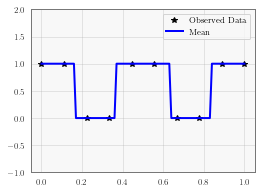

In [5]:
# Go into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    # Test x are regularly spaced by 0.01 0,1 inclusive
    test_x = torch.linspace(0, 1, 101)
    # Get classification predictions
    observed_pred = likelihood(model(test_x))

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Get the predicted labels (probabilites of belonging to the positive class)
    # Transform these probabilities to be 0/1 labels
    pred_labels = observed_pred.mean.ge(0.5).float()
    ax.plot(test_x.numpy(), pred_labels.numpy(), 'b')
    ax.set_ylim([-1, 2])
    ax.legend(['Observed Data', 'Mean'])

## Notes on other Non-Gaussian Likeihoods

The Bernoulli likelihood is special in that we can compute the analytic (approximate) posterior predictive in closed form. That is: $q(\mathbf y) = E_{q(\mathbf f)}[ p(y \mid \mathbf f) ]$ is a Bernoulli distribution when $q(\mathbf f)$ is a multivariate Gaussian.

Most other non-Gaussian likelihoods do not admit an analytic (approximate) posterior predictive. To that end, calling `likelihood(model)` will generally return Monte Carlo samples from the posterior predictive.

In [6]:
# Analytic marginal
likelihood = gpytorch.likelihoods.BernoulliLikelihood()
observed_pred = likelihood(model(test_x))
print(
    f"Type of output: {observed_pred.__class__.__name__}\n"
    f"Shape of output: {observed_pred.batch_shape + observed_pred.event_shape}"
)

Type of output: Bernoulli
Shape of output: torch.Size([101])


In [7]:
# Monte Carlo marginal
likelihood = gpytorch.likelihoods.BetaLikelihood()
with gpytorch.settings.num_likelihood_samples(15):
    observed_pred = likelihood(model(test_x))
print(
    f"Type of output: {observed_pred.__class__.__name__}\n"
    f"Shape of output: {observed_pred.batch_shape + observed_pred.event_shape}"
)
# There are 15 MC samples for each test datapoint

Type of output: Beta
Shape of output: torch.Size([15, 101])


See [the Likelihood documentation](http://gpytorch.readthedocs.io/en/stable/likelihoods.html#likelihood) for more details.